# AOB MC Data Exploration
The goal of this notebook is to take in data from Zhuang et al. (see other notebooks) and be able to explore spatial transcriptomics of AOB MCs, specifically. This will be done in a few steps including:
* data loading
* joining dataframes
* filtering for excitatory neurons within the accessory olfactory bulb
* visualizing genetic diversity of these neurons

This notebook has been created to enable greater visualization of the analysis performed in AOB_MC_data_exploration.py within this repository. Please note that much of this code has been adapted from code provided by the Allen Brain Institute.

In [1]:
# if using for the first time, you will need to download the Allen Brain-specific functions:
!pip install "abc_atlas_access[notebooks] @ git+https://github.com/alleninstitute/abc_atlas_access.git"

  Cloning https://github.com/alleninstitute/abc_atlas_access.git to c:\users\kevjm\appdata\local\temp\pip-install-bgyyz6pe\abc-atlas-access_2ac1866e72c04a7381156c9c1d63f569
  Resolved https://github.com/alleninstitute/abc_atlas_access.git to commit 398c9cc557a4b1e75dc68dd3d4965d3ed50367b2
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/785.6 kB ? eta -:--:--
   --------------------------------------- 785.6/785.6 kB 14.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/13.9 MB ? eta -:--:--
   ------------ --------------------------- 4.2/13.9 MB 19.9 MB/s eta 0:00:01
   -------------------- ------------------- 7.1/13.9 MB 18.5 MB/s eta 0:00:01
   

  Running command git clone --filter=blob:none --quiet https://github.com/alleninstitute/abc_atlas_access.git 'C:\Users\kevjm\AppData\Local\Temp\pip-install-bgyyz6pe\abc-atlas-access_2ac1866e72c04a7381156c9c1d63f569'
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.19.0 requires botocore<1.36.4,>=1.36.0, but you have botocore 1.39.13 which is incompatible.


## Imports, Definintions, and Loading of Relevant Data

In [2]:
# import relevant libraries and Allen-specific packages to engage with datasets
import pandas as pd
from pathlib import Path
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

### Defining plotting functions provided by Allen Brain

In [28]:
# defining functions for visualization
# This code has been provided by the Allen Brain Institute
def subplot_section(ax, xx, yy, cc = None, val = None, cmap = None) :
    
    if cmap is not None :
        ax.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None :
        ax.scatter(xx, yy, s=0.5, color=cc, marker='.')
    ax.set_ylim(11, 0)
    ax.set_xlim(0, 11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])


def plot_sections(cell_extended, example_section, cc = None, val = None, fig_width = 10, fig_height = 10, cmap = None) :
    
    fig, ax = plt.subplots(2, 2)
    fig.set_size_inches(fig_width, fig_height)
    
    for i, d in enumerate(cell_extended):
        
        pred = (cell_extended[d]['brain_section_label'] == example_section[d])
        section = cell_extended[d][pred] 
        
        if cmap is not None :
            subplot_section( ax.flat[i], section['x'], section['y'], val=section[val], cmap=cmap)
        elif cc is not None :
            subplot_section( ax.flat[i], section['x'], section['y'], section[cc])
            
        ax.flat[i].set_title(d)
        
    return fig, ax


def plot_heatmap(df, fig_width = 8, fig_height = 4, cmap=plt.cm.magma_r, vmax=None):

    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    res = ax.imshow(arr, cmap=cmap, aspect='auto', vmax=vmax)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)

### Importing data

In [4]:
# labels for all Zhuang datasets
datasets = ['Zhuang-ABCA-1', 'Zhuang-ABCA-2', 'Zhuang-ABCA-3'] #excluding ...-4 as it does not have any AOB neurons
# loading / caching relevant data:
# download_base = Path('C:/Users/IGD/Documents/KJM/data/abc_10x/data/abc_atlas') # work computer
download_base = Path('C:/Users/kevjm/Documents/Python/downloaded_data/ABC_10X') # personal laptop
abc_cache = AbcProjectCache.from_cache_dir(download_base)

## Analysis Pipeline

### Create variable cell_extended to contain data from provided datasets
These next few cells will download and combine relevant data for future analysis. Some notes:
* Cluster refers to the clusters ABI defined based on genes expressed
* CCF refers to the coordinates of a given cell within the ABI centralized framework
* Parcellation refers to the brain area where a cell was found

The steps within the following cells are performed by the create_cell_extended function defined in combining_filtering_abc_data.py within this repository

In [5]:
# Step 1: Reading in cluster details and providing color for consistent labeling
cluster_details = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership_pivoted',
    keep_default_na=False
)

cluster_details.set_index('cluster_alias', inplace=True)
cluster_colors = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership_color',
)
cluster_colors.set_index('cluster_alias', inplace=True)

In [6]:
# Step 2: Load in cell metadata and coordinate information
# for each dataframe (as defined by list above)
print('Creating components...')
cell = {}
ccf_coordinates = {}
for d in datasets :
    #for each dataset, 
    # load in the metadata
    cell[d] = abc_cache.get_metadata_dataframe(
        directory=d,
        file_name='cell_metadata',
        dtype={"cell_label": str}
    )
    cell[d].set_index('cell_label', inplace=True)
    sdf = cell[d].groupby('brain_section_label')          
    print(d,":","Number of cells = ", len(cell[d]), ", ", "Number of sections =", len(sdf))

    # and load in the coordinate information
    ccf_coordinates[d] = abc_cache.get_metadata_dataframe(directory=f"{d}-CCF", file_name='ccf_coordinates')
    ccf_coordinates[d].set_index('cell_label', inplace=True)
    ccf_coordinates[d].rename(columns={'x': 'x_ccf',
                                       'y': 'y_ccf',
                                       'z': 'z_ccf'},
                              inplace=True)

Creating components...
Zhuang-ABCA-1 : Number of cells =  2846908 ,  Number of sections = 147
Zhuang-ABCA-2 : Number of cells =  1227408 ,  Number of sections = 66
Zhuang-ABCA-3 : Number of cells =  1585843 ,  Number of sections = 23


In [7]:
#Step 3: Load in Parcellation Data (defines what brain region a cell is in)
parcellation_annotation = abc_cache.get_metadata_dataframe(directory="Allen-CCF-2020",
                                                           file_name='parcellation_to_parcellation_term_membership_acronym')   
parcellation_annotation.set_index('parcellation_index', inplace=True)
parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]
parcellation_color = abc_cache.get_metadata_dataframe(directory="Allen-CCF-2020",      
                                                      file_name='parcellation_to_parcellation_term_membership_color')
parcellation_color.set_index('parcellation_index', inplace=True)
parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]

In [8]:
#Step 4: Combine all relevant data into cell_extended variable
cell_extended = {}
for d in datasets :
    cell_extended[d] = cell[d].join(cluster_details, on='cluster_alias')
    cell_extended[d] = cell_extended[d].join(cluster_colors, on='cluster_alias')
    cell_extended[d] = cell_extended[d].join(ccf_coordinates[d], how='inner')
    cell_extended[d] = cell_extended[d].join(parcellation_annotation, on='parcellation_index')
    cell_extended[d] = cell_extended[d].join(parcellation_color, on='parcellation_index')

### Filtering expression data to AOB Glutamatergic Neurons
These cells will select from the whole-brain datasets only those cells that are (1) within the accessory olfactory bulb (AOB) and (2) use glutamate as their neurotransmitter. Within the AOB, glutamatergic neurons are either mitral or tufted cells; here we are combining them as one population.

The steps within the following cells are performed by the filter_cell_extended function defined in combining_filtering_abc_data.py within this repository

In [9]:
# Define filtering parameters
structure_mask = 'AOB'
nt_mask = 'Glut'

# creating a new dataframe only with glutamatergic cells within the olfactory bulb
cell_extended_filt = {}
for key in cell_extended:
    curr_df = cell_extended[key]
    cell_extended_filt[key] = curr_df.loc[
        (curr_df['parcellation_structure'] == structure_mask) &
        (curr_df['neurotransmitter'] == nt_mask)]
    print(f'{key}: {cell_extended_filt[key].shape[0]} {nt_mask}-ergic neurons within {structure_mask}')

Zhuang-ABCA-1: 1050 Glut-ergic neurons within AOB
Zhuang-ABCA-2: 370 Glut-ergic neurons within AOB
Zhuang-ABCA-3: 458 Glut-ergic neurons within AOB


### Add gene expression data to the filtered dataframe
The following cells will retrieve gene expression data for each cell from one dataframe and merge it with the filtered dataframe created above. This will be done through defining a function that takes a dataframe and list of gene names.

With a defined function, we can then add an arbitrary amount of genetic data based on certain genes of interest. The code within the following cells is recapitulated in AOB_MC_data_exploration.py and the function add_gene_expression within the combining_filtering_abc_data.py files within this repository

In [10]:
# First define a function that adds genetic expression data to a dataframe
def add_gene_expression(cell_extended,genes):
    """
    This function incorporates genetic expression data into 
    a cell_extended dictionary of dataframes. cell_extended is a dictionary of 
    dataframes and genes is a dataframe with information for screened genes.
    """
    
    print(f'Finding expression data for {len(genes)} genes')
    # download_base = Path('C:/Users/IGD/Documents/KJM/data/abc_10x/data/abc_atlas') # work computer
    download_base = Path('C:/Users/kevjm/Documents/Python/downloaded_data/ABC_10X') # personal laptop
    abc_cache = AbcProjectCache.from_cache_dir(download_base)
    
    cell_w_genex = {}
    for key in cell_extended:    
        file = abc_cache.get_data_path(directory=key, 
                                       file_name=f"{key}/log2")
        
        adata = anndata.read_h5ad(file, backed='r')
        
        start = time.process_time()
        gdata = adata[:, genes.index].to_df()
        gdata.columns = genes.gene_symbol
        cell_w_genex[key] = cell_extended[key].join(gdata)
        
        print(key,"-","time taken: ", time.process_time() - start)
        
        adata.file.close()
        del adata
    
    return cell_w_genex

With the function defined, we can name the genes of interest. Note that ABC screened for 1k+ genes which could take a bit of time. Below, I have included code that looks at expression data for a select set of genes.

In [11]:
# First, load in all gene expression data
# loading in gene data
genes = abc_cache.get_metadata_dataframe(directory=datasets[0],
                                        file_name='gene')
genes.set_index('gene_identifier', inplace=True)

In [12]:
# you can filter the genes based on a set list, but it must be a dataframe
#for example, here we are selecting a subset of screened genes
gnames = ['Slc17a6','Slc32a1','Gnrh1','Esr1','Esr2','Npy1','Npy2','Cyp19a1','Tac2','Crhr1','Crhr2']
gene_bool = [x in gnames for x in genes.gene_symbol]
genes_filtered = genes[gene_bool]

cell_extended_filt_genex = add_gene_expression(cell_extended_filt,genes_filtered)

Finding expression data for 9 genes
Zhuang-ABCA-1 - time taken:  40.921875


Zhuang-ABCA-2-log2.h5ad: 100%|██████████| 871M/871M [00:35<00:00, 24.2MMB/s]    


Zhuang-ABCA-2 - time taken:  25.71875


Zhuang-ABCA-3-log2.h5ad: 100%|██████████| 1.16G/1.16G [00:49<00:00, 23.3MMB/s]   


Zhuang-ABCA-3 - time taken:  29.03125


If you wanted to look at the expression data for all genes, then you would skip the filtering step above and pass the genes dataframe as the second argument within the add_gene_expression function.

### Combine separate dataframes into single
Right now, the three datasets (Zhuang...-1, Zhuang...-2, and Zhuang...-3) are stored within a dictionary of dataframes. For cross-experiment analysis, we need to combine them into a single dataframe

In [13]:
#with all data compiled, we can combine across dataframes as follows
df_all_datasets = pd.DataFrame()
for k in cell_extended_filt_genex:
    df_all_datasets = pd.concat([df_all_datasets,
                                 cell_extended_filt_genex[k]])

## Data Visualization

We can now begin visualizing the data! First step is to look at gene expression across neurons for the genes listed above.

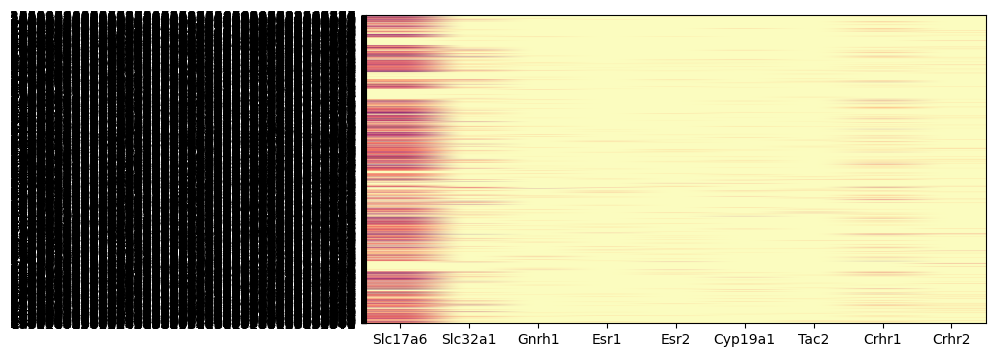

In [29]:
#this line is included in case there are genes within the list that aren't actually in the allen dataset
gnames_in_df = [g_name for g_name in gnames if g_name in df_all_datasets.columns] 
plot_heatmap(df_all_datasets[gnames_in_df])

This plot is difficult to interpret given that each row is an individual neuron (almost 1900!). Fortunately, the Allen Institute has already created cell classes which we can use for data visualization as follows:

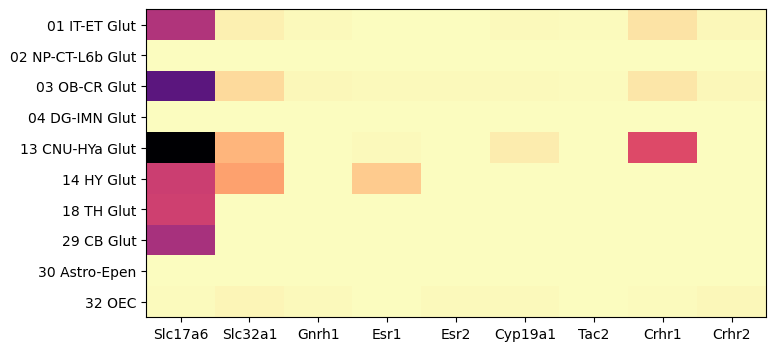

In [17]:
df_gene_exp_by_class = df_all_datasets.groupby('class')[gnames_in_df].mean()
plot_heatmap(df_gene_exp_by_class[gnames_in_df])

Here we can see how provided class labels provide a more interpretable heatmap. Namely, most gluatmatergic neurons express Slc17a6 (vGlut) and only a few express Slc32a1 (vGAT). In addition, the 1-type receptor for CRH seems specifically enhanced in the 13 CNU-HYa Glut class; interestingly, this class alos seems to have some expression of aromatase (Cyp19a1). While these classes are useful, I would like to perform my own classification strategies based on all genes expressed to see if there are more explanatory class labels if we consider just AOB neurons.

This is an ongoing project for me and this notebook (along with the other files within this repository) will be updated accordingly. A few questions that I'd like to tackle first are:
1) What subpopulations of AOB glutamatergic cells are there? We know that ABI has clustered neurons throughout the brain, but can we define our own clusters of AOB neurons? To this end, I anticipate using dimensionality reduction (e.g., PCA) and clustering algorithms (e.g., hierarchical/agglomerative clustering, k-means clustering, etc.).
2) Additionally, these datasets contain genetic expression from male and female mice; I would like to know whether there are any sexually dimorphisms in gene expression. To this end, we can create a sexual dimorphism metric by subtracting the average expression of genes in male datasets from female datasets. From this, we can find whether any genes are more strongly expressed in males or females.
3)  Finally, each cell has an anatomical location within the AOB. Sensory input into the AOB is known to be anatomically separate (i.e., sensory neurons expressing the V1-type receptor innervate the anterior AOB whereas sensory neurons expressing hte V2-type receptor innervate the posterior AOB). Are there any genes that have distinct anatomical patterns of expression? To address this, we can define a histogram across the AP axis within the AOB for each gene. Then, we can create a metric with distribution statistics (e.g., median, standard deviation, skew, etc.) to define whether a gene shows specific anatomical patterning.